**Importing Packages**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yfc
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set()

**Loading Data from yFinance**

In [8]:
raw_data = yfc.download( tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2022-09-27", interval = "1d", group_by = "ticker", auto_adjust = True, treads = True )
df_complete = raw_data.copy()
# New Columns Data Set
df_complete['spx'] = df_complete['^GSPC'].Close
df_complete['ftse'] = df_complete['^FTSE'].Close

# Removing first element
df_complete = df_complete[1:]

# Removing original columns
del df_complete['^GSPC']
del df_complete['^FTSE']

[*********************100%***********************]  4 of 4 completed

4 Failed downloads:
- ^GDAXI: No data found for this date range, symbol may be delisted
- ^GSPC: No data found for this date range, symbol may be delisted
- ^N225: No data found for this date range, symbol may be delisted
- ^FTSE: No data found for this date range, symbol may be delisted


**Load Data and Transform from CSV**

In [39]:
raw_csv_data = pd.read_csv('../Intro/IndexE8.csv')
df_complete = raw_csv_data.copy()

df_complete['market_value'] = df_complete.spx

# Transform Date column to the type Date
df_complete.date = pd.to_datetime(df_complete.date, dayfirst = True)

# Setting Date as Index
df_complete.date = df_complete.set_index('date', inplace = True)

# Setting Frequency as Business Day
df_complete = df_complete.asfreq('b')

# Fill empty values -> Front Fill
df_complete = df_complete.fillna(method = 'ffill')

del df_complete['dax']
del df_complete['ftse']
del df_complete['nikkei']
del df_complete['spx']

# Getting 80% of the Data Set
size = int(len(df_complete) * 0.8)

# Setting Train and Test
df_train, df_test = df_complete.iloc[:size], df_complete.iloc[size:]

**White Noise**

In [40]:
wn = np.random.normal(
    loc = df_train.market_value.mean(),
    scale = df_train.market_value.std(),
    size = len(df_train)
)

In [41]:
# Adding White Noise to DataFrame
df_train['wn'] = wn

C:\Users\Yago\AppData\Local\Temp\ipykernel_17100\3143756099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['wn'] = wn


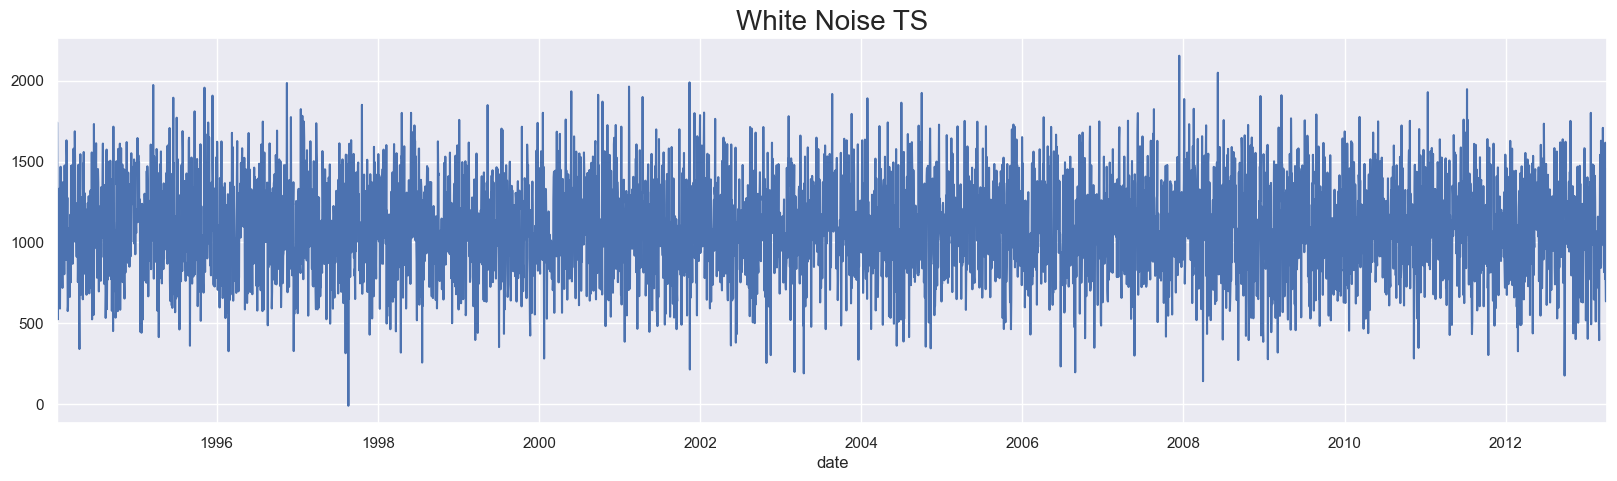

In [42]:
df_train.wn.plot(figsize = (20, 5))
plt.title("White Noise TS", size = 20)
plt.show()

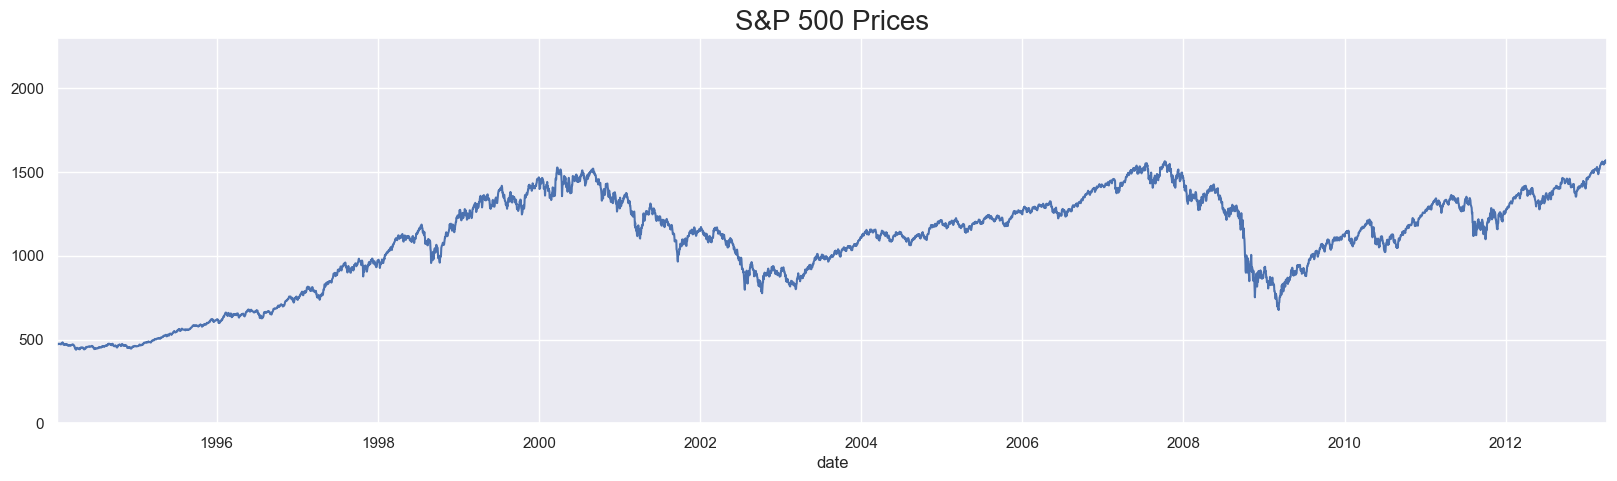

In [43]:
df_train.market_value.plot(figsize = (20, 5))
plt.title("S&P 500 Prices", size = 20)
plt.ylim(0, 2300)
plt.show()

**Random Walk**

In [44]:
'''
    Random Walk -> Is a type of Time-Series that values tend to persist over time and the differences
                   between periods are simply white noise.
'''
rw = pd.read_csv('RandWalk.csv')

# Transforming de type of the column Date in Date Type
rw.date = pd.to_datetime(rw.date, dayfirst=True)

# Set column Date as Index
rw.set_index('date', inplace=True)

# Set frequency as Business Day
rw = rw.asfreq('b')

In [45]:
df_train['rw'] = rw.price

df_train.head()

C:\Users\Yago\AppData\Local\Temp\ipykernel_17100\239398303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['rw'] = rw.price


,market_value,wn,rw
date,,,
1994-01-07,469.90,1740.648382,1122.139662
1994-01-10,475.27,1188.391451,1080.347860
1994-01-11,474.13,524.462494,1082.095245
1994-01-12,474.17,935.197041,1083.639265
1994-01-13,472.47,1225.781956,1067.146255


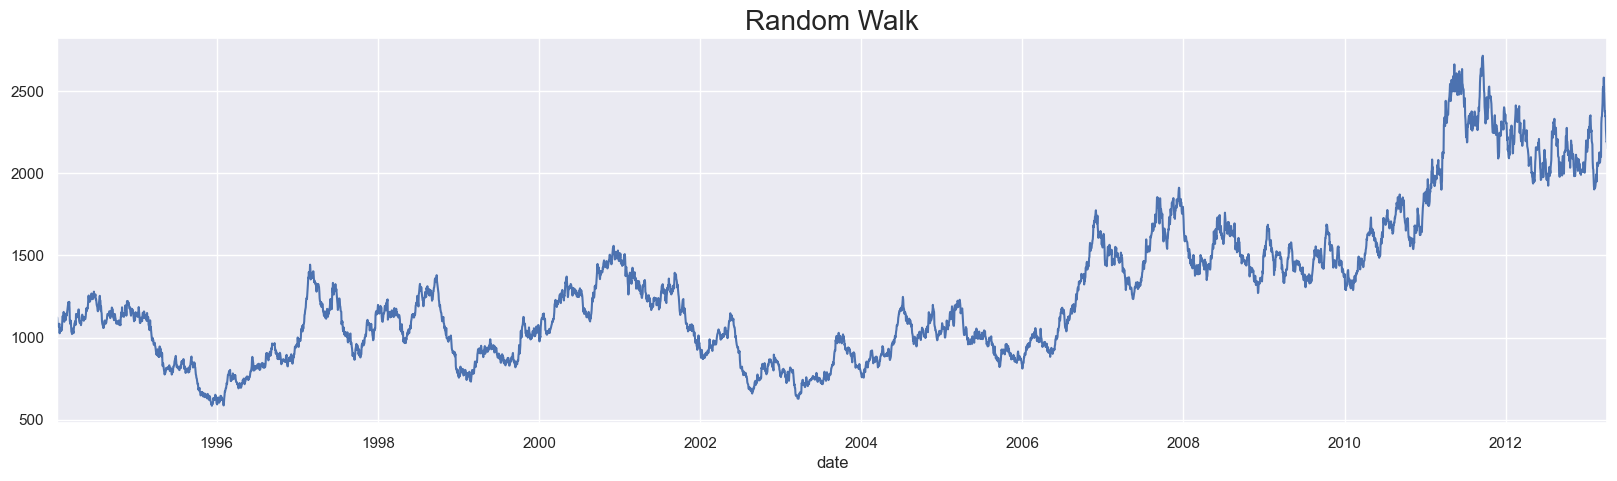

In [47]:
df_train.rw.plot(figsize = (20, 5))
plt.title("Random Walk", size = 20)
plt.show()

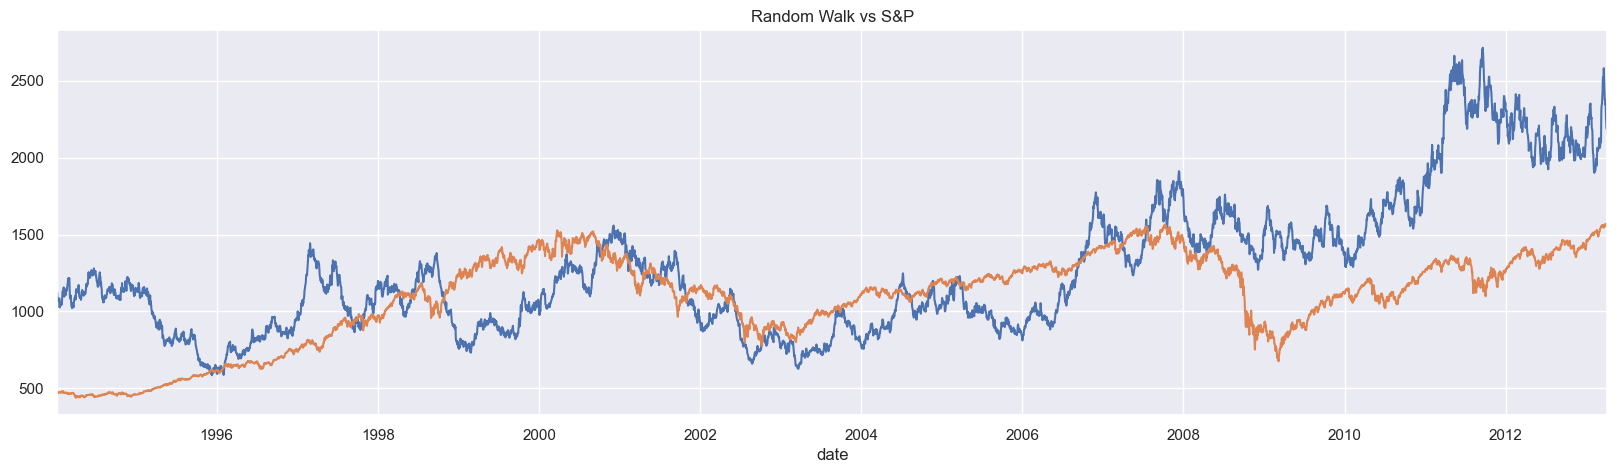

In [48]:
df_train.rw.plot(figsize = (20, 5))
df_train.market_value.plot()
plt.title("Random Walk vs S&P")
plt.show()

**Stationary**

In [49]:
'''
    Covariance Stationarity -> Taking consecutives samples of data with the same size, should have identical covariance, regardless of the starting point.
    Strict Stationarity -> Samples with identical size should have identical distributions. Mathematically, a time series {Xt} is called strictly stationary if the random vectors (Xt1 ,...,Xtn )T and (Xt1+τ,...,Xtn+τ)T have the same
    joint distribution for all sets of indices {t1,...,tn} and for all integers τ and n > 0.
    Proprieties:
         - Constant Mean
         - Variance
         - Consistent Covariance

    Dickey-Fuller Test -> Check whether a Data Set comes from a Stationary Process
'''
# First Element -> Statistical Result
# Second Element -> Express the PValue associated with the statistic, in the results it suggests that it has 41% of not rejecting the Non-Stationary
# Third Element -> Represents the number of lags used in the regression when determining the statistic result, in this case it is 18, so there is some auto-correlation between
# Fourth Element -> The number of observations used for the ADF regression and calculation of the critical values, usually adds up in the size of the data set.
# Object Element -> Critical Values from the Dickey-Fuller table
# Last Element -> Estimates maximize information criteria provided if there is some apparent auto-correlation, the lower the values the easier to make prediction for future
sts.adfuller(df_train.market_value)

(-1.7369847452352438,
 0.4121645696770621,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

In [50]:
''' Expect to get a very low AP value, since there is no auto-correlation in WhiteNoise there should be no noise and no lag involved in the regression  '''
sts.adfuller(df_train.wn)

(-71.09479061783817,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 70804.51465034326)

In [51]:
sts.adfuller(df_train.rw)

(-1.328607392768972,
 0.6159849181617384,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

**Seasonality**

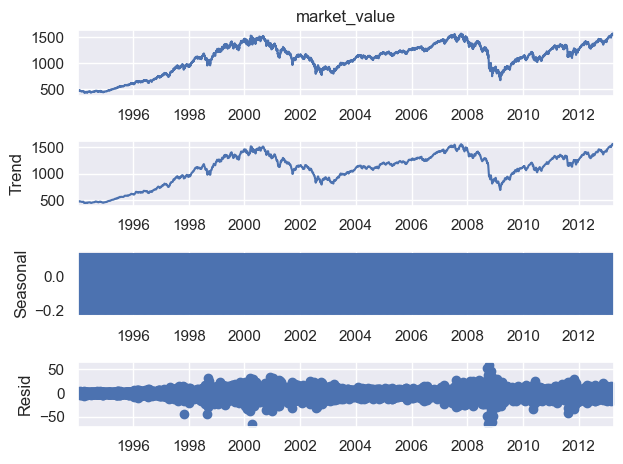

In [52]:
'''
    Seasonality -> Trends will appear on a cyclical basis. There is several ways to test it, one approach is Decomposition, where it splits the Time Series in 3 effects:
        - Trend    -> Pattern consistent through out the Data
        - Seasonal -> All cyclical effects duo to seasonary
        - Residual -> Error of prediction or the difference between the actual data and the model with it
    Naive Decomposition -> Expect linear relation between the three parts and observe time series. There is 2 main approach for this decomposition:
        - Additive       ->   ⁂ observed = trend + seasonal + residual
        - Multiplicative ->   ⁂ observed = trend * seasonal * residual
'''
s_dec_additive = seasonal_decompose(df_train.market_value, model = 'additive')
s_dec_additive.plot()
plt.show()

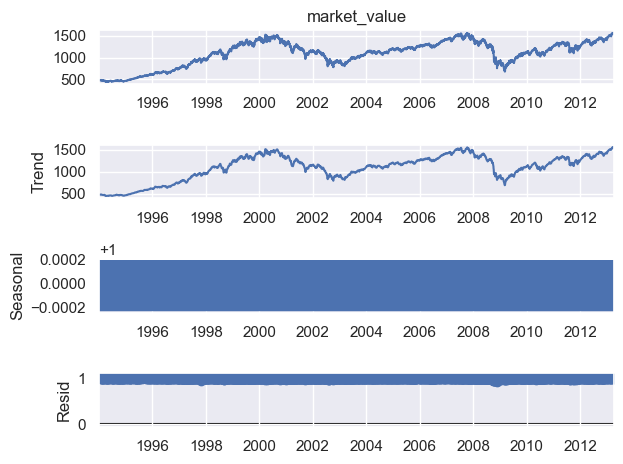

In [53]:
s_dec_multipicative = seasonal_decompose(df_train.market_value, model = 'multiplicative')
s_dec_multipicative.plot()
plt.show()

**Autocorrelation -> ACF**

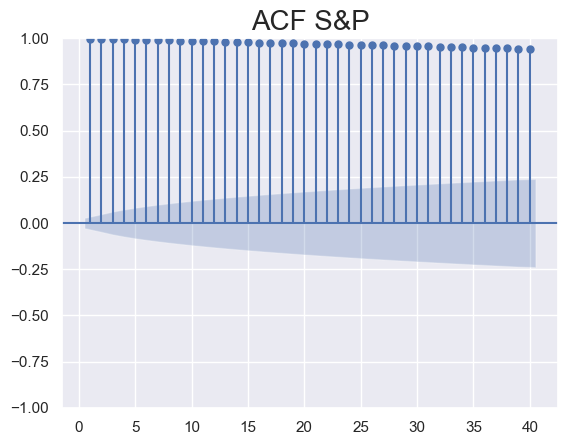

In [57]:
''' The correlation between a sequence and itself, it measures the similarity between a time series and a lag version of itself. '''
sgt.plot_acf(df_train.market_value, lags = 40, zero = False)
plt.title("ACF S&P", size = 20)
plt.show()

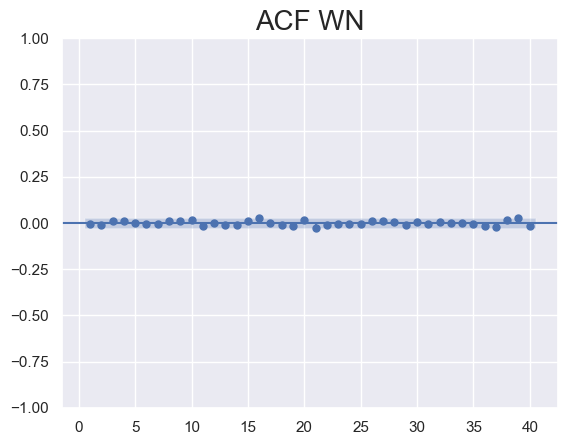

In [58]:
sgt.plot_acf(df_train.wn, lags = 40, zero = False)
plt.title("ACF WN", size = 20)
plt.show()

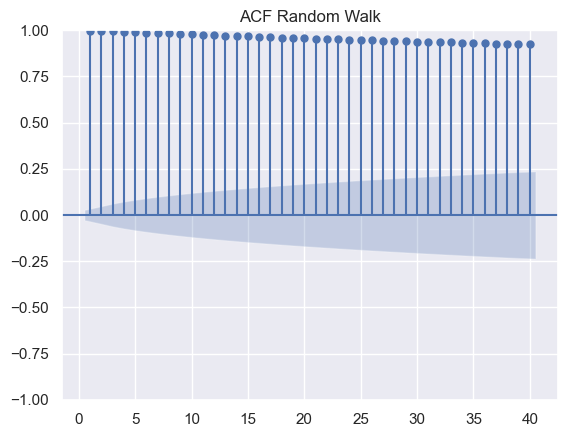

In [59]:
sgt.plot_acf(df_train.rw, lags = 40, zero = False)
plt.title("ACF Random Walk")
plt.show()

**Partial Autocorrelation Function -> PACF**

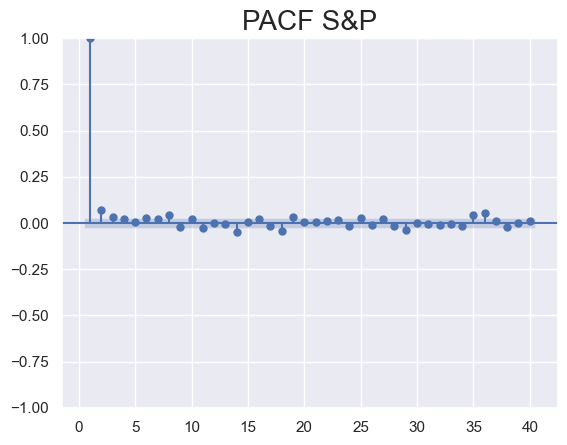

In [60]:
''' PACF -> Cancel out all the additional channels a previous period value affects the present one'''
sgt.plot_pacf(df_train.market_value, lags = 40, zero = False, method = ('ols'))
plt.title("PACF S&P", size = 20)
plt.show()

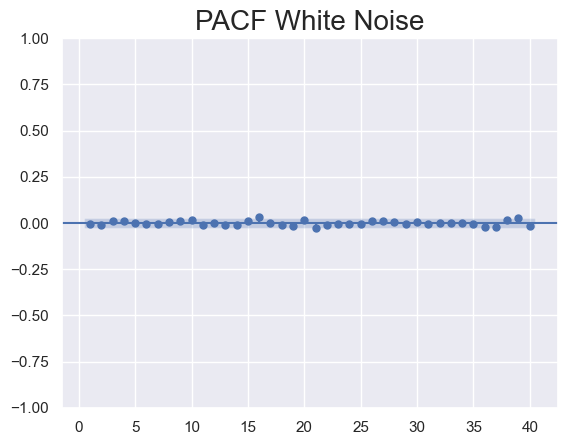

In [61]:
sgt.plot_pacf(df_train.wn, lags = 40, zero = False, method = ('ols'))
plt.title("PACF White Noise", size = 20)
plt.show()

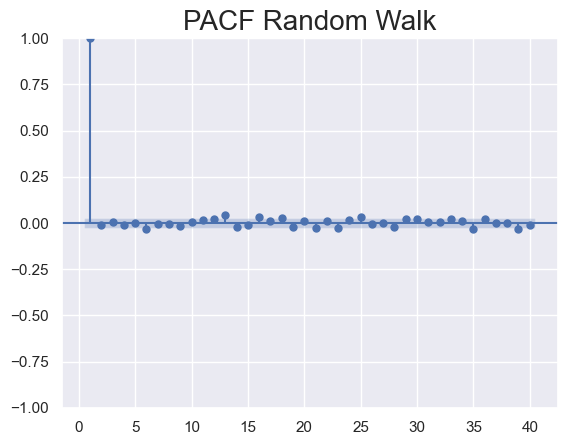

In [62]:
sgt.plot_pacf(df_train.rw, lags = 40, zero = False, method = ('ols'))
plt.title('PACF Random Walk', size = 20)
plt.show()